Scrape Data from Craiglist Housing with Selenium and BeautifulSoup

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

from datetime import datetime
import math
import re


In [3]:
#Helper Function
def substring_after(s, delim):
    return s.partition(delim)[2]

In [4]:
class CraiglistScraper(object):
    def __init__(self, url):
        self.url = url
        self.driver = webdriver.Firefox()
        self.driver.get(self.url)
        self.delay = 3

    def test(self):
        print(self.url)

    def print_total(self): 
        # Help getting the total number of available postings 
        str = self.driver.find_element(By.CLASS_NAME,"cl-page-number").text
        total_pages = int( substring_after(str, " of").replace(' ','').replace(',',''))
        return total_pages

    def load_craiglist_url(self):
        self.driver.get(self.url)
        try:
            wait = WebDriverWait(self.driver, self.delay)
            wait.until(EC.presence_of_all_elements_located((By.CLASS_NAME, "cl-search-result")))
            print("Page is ready")
        except TimeoutException:
            print("Time out!")

    def extract_post_info(self):
        dates, titles, bdrs, sqfts, prices, urls = ( [] for i in range(6))
        listings = self.driver.find_elements(By.CLASS_NAME,"cl-search-result") 

        # Loop through each listing and extract details
        for index, listing in enumerate(listings):
            try:
                # Extract title (label)
                try:
                    title = listing.find_element(By.CLASS_NAME, "label").text
                except:
                    title = "N/A"

                # Extract link
                try:
                    link = listing.find_element(By.CLASS_NAME, "posting-title").get_attribute("href")
                except:
                    link = "N/A"

                # Extract price
                try:
                    price = listing.find_element(By.CLASS_NAME, "priceinfo").text
                except:
                    price = "N/A"

                # Extract bedrooms
                try:
                    bedrooms = listing.find_element(By.CLASS_NAME, "post-bedrooms").text
                except:
                    bedrooms = "N/A"

                # Extract square footage
                try:
                    sqft = listing.find_element(By.CLASS_NAME, "post-sqft").text
                except:
                    sqft = "N/A"

                # Extract time posted
                try:
                    time_element = listing.find_element(By.CSS_SELECTOR, 'span[title]')
                    time_full = time_element.get_attribute("title")  # Example: "Fri Jan 31 2025 01:17:11 GMT-0800 (Pacific Standard Time)"
                except:
                    time_full = "N/A"

                # print(f"Listing {index + 1}:")
                # print(f"  Title: {title}")
                # print(f"  Link: {link}")
                # print(f"  Price: {price}")
                # print(f"  Bedrooms: {bedrooms}")
                # print(f"  Square Footage: {sqft}")
                # print(f"  Time Posted: {time_text} ({time_full})")
                # print("-" * 50)

                # Store values in lists
                dates.append(time_full)
                titles.append(title)
                bdrs.append(bedrooms)
                urls.append(link)
                sqfts.append(sqft)
                prices.append(price)

            except Exception as e:
                print(f"Error extracting listing {index + 1}: {e}")

        return dates,titles,bdrs,urls,sqfts,prices


    def quit(self):
        self.driver.close()



In [5]:
areas = {
    "vancouver": ['rch', 'rds', 'nvn', 'bnc', 'pml', 'van'],
    "toronto": ['bra', 'tor', 'drh', 'mss', 'oak', 'yrk'],
    "other": ['victoria', 'winnipeg', 'abbotsford', 'calgary', 'edmonton', 'halifax', 'hamilton', 'kitchener', 'ottawa']
}

post_titles, post_area, post_price, post_dates, post_brs, post_sqft, post_urls = ([] for _ in range(7))

for region, cities in areas.items():
    for city in cities:
        total_page, start = 10000, 0
        base_url_template = (
            f"https://vancouver.craigslist.org/search/{{}}/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~{{}}~0"
            if region == "vancouver" else
            f"https://toronto.craigslist.org/search/{{}}/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~{{}}~0"
            if region == "toronto" else
            f"https://{{}}.craigslist.org/search/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~{{}}~0"
        )

        while start < total_page:
            base_url = base_url_template.format(city, start)
            scraper = CraiglistScraper(base_url)
            scraper.test()
            scraper.load_craiglist_url()

            if total_page == 10000:
                listingsnumber = scraper.print_total()
                total_page = math.ceil(listingsnumber / 120)
                print("Total pages:", total_page)

            info = scraper.extract_post_info()
            post_dates += info[0]
            post_titles += info[1]
            post_brs += info[2]
            post_urls += info[3]
            post_sqft += info[4]
            post_price += info[5]
            post_area += [city] * len(info[0])
            
            start += 1
            scraper.quit()




https://vancouver.craigslist.org/search/rch/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~0~0
Page is ready
Total pages: 4
https://vancouver.craigslist.org/search/rch/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~1~0
Page is ready
https://vancouver.craigslist.org/search/rch/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~2~0
Page is ready
https://vancouver.craigslist.org/search/rch/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~3~0
Page is ready
https://vancouver.craigslist.org/search/rds/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~0~0
Page is ready
Total pages: 14
https://vancouver.craigslist.org/search/rds/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~1~0
Page is ready
https://vancouver.craigslist.org/search/rds/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~2~0
Page is ready
https://vancouver.craigslist.org/search/rds/apa?hasPic=1&housing_type=1&housing_type=2#search=1~list~3~0
Page is ready
https://vancouver

In [6]:
print(len(post_titles))
print(len(post_area))
print(len(post_price))
print(len(post_dates))
print(len(post_brs))
print(len(post_sqft))
print(len(post_urls))

11940
11940
11940
11940
11940
11940
11940


In [14]:
import pandas
import emoji

df = pandas.DataFrame(data ={"Title": post_titles , "Area": post_area, "Price": post_price, "Date": post_dates,
                              "Number of Bedroom": post_brs, "Square Feet": post_sqft, "URL": post_urls})

### CLEAN DATA

# The first letter of each word is capitalized
df['Title'] = df['Title'].str.lower().str.title()

# Keep only the numeric values for 'Number of Bedroom'
df['Number of Bedroom'] = df["Number of Bedroom"].str.replace('br', '', regex=False).str.extract('(\d+)').astype(float)

# Drop NaNs and filter for 1, 2, or 3 bedrooms
df = df.dropna(subset= ['Number of Bedroom'])
df = df.loc[df['Number of Bedroom'].isin([1,2,3])]

df= df.dropna(subset= ['Price'])
df= df.loc[df['Price'] != 'N/A']
df['Area'] = df['Area'].replace(['bnc','rds','nvn','rch','pml','van'],['Burnaby/Newwest','Delta/Surrey/Langley', 'North Shore' , 'Richmond', 'Tricities/Pitt/Maple','Vancouver'])
df['Area'] = df['Area'].replace(['bra','tor','drh','mss','oak','yrk'],['Brampton', 'City of Toronto', 'Durham Region', 'Mississauga', 'Oakville', 'York Region'])
df['Area'] = df['Area'].str.capitalize()

df = df.drop_duplicates(subset= ['Title','Price','Number of Bedroom','Square Feet'])
# #df['Square Feet'] = df['Square Feet'].mask(df['Square Feet']>3000) # Convert Square Feet to Nan when its more than 3000
# #df = df[ df.Title.str.lower().str.contains("rv pad") != True] # "RV Pad" edge cases
# df['Title'] = df['Title'].apply(lambda s: emoji.replace_emoji(s, '')) # Remove emojis

print("Number of Postings is ", len(df))

Number of Postings is  9707


In [15]:
print(df)

                                                   Title      Area   Price  \
0      Ocean View Huge 1 Bed 1 Bath + Huge Balcony Co...  Richmond  $2,400   
1      Renters Dream House 3 Bdrm Suite Upstairs With...  Richmond  $5,500   
2      Newer Penthouse Unit With Ac And Central Locat...  Richmond  $3,500   
3      (Plh_Ref#9171)1000 Sqft Large Condo, 2Beds 2Ba...  Richmond  $2,950   
4      Richmond Centre 2Bedrooms 2Baths Apartment For...  Richmond  $2,850   
...                                                  ...       ...     ...   
11935  Winter Promotion, Save $3600.Brand New Apartme...    Ottawa  $1,725   
11936             2B1B Apartment Lease Takeover/Transfer    Ottawa  $1,474   
11937         2Bedroom Apartment Lease Takeover/Transfer    Ottawa  $1,474   
11938                   Good Location  Face A La Riviere    Ottawa  $1,595   
11939  8 Month Lease Assignment With Opportunity To R...    Ottawa  $2,550   

                                                    Date  Numbe

In [16]:
# Save the DataFrame to a CSV file
csv_filename = "craigslist_listings_pandas.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8")

print(f"\n✅ Data successfully saved to {csv_filename}")

PermissionError: [Errno 13] Permission denied: 'craigslist_listings_pandas.csv'

In [17]:
#Remove Outliers
df['Price'] = df['Price'].astype(str).str.replace(r'[\$,]','',regex=True).astype(int)
Q1 = df['Price'].quantile(0.25)
Q3 = df['Price'].quantile(0.75)
print(Q1)
IQR = Q3 - Q1

df = df[~((df['Price'] < (Q1 - 1.5 * IQR)) |(df['Price'] > (Q3 + 1.5 * IQR)))]
print("Number of Postings is ", len(df))
df.to_csv("./Housing_Craiglist.csv", sep=',',index=False)

2100.0
Number of Postings is  9234


In [18]:
#Calling the .describe() method to get a more detailed look.
one_br = df.loc[ (df['Number of Bedroom'] == 1) ]
one_br.describe().round(2)

,Price,Number of Bedroom
count,4811.00,4811.0
mean,2257.19,1.0
std,490.61,0.0
min,750.00,1.0
25%,1948.00,1.0
50%,2255.00,1.0
75%,2550.00,1.0
max,4350.00,1.0


In [19]:
two_br = df.loc[ (df['Number of Bedroom'] == 2) ]
two_br.describe().round(2)

,Price,Number of Bedroom
count,3954.00,3954.0
mean,2815.31,2.0
std,616.49,0.0
min,800.00,2.0
25%,2450.00,2.0
50%,2800.00,2.0
75%,3200.00,2.0
max,4350.00,2.0


In [20]:
three_br = df.loc[df['Number of Bedroom'] == 3 ]
three_br.describe().round(2)

,Price,Number of Bedroom
count,469.00,469.0
mean,3160.51,3.0
std,711.70,0.0
min,750.00,3.0
25%,2795.00,3.0
50%,3200.00,3.0
75%,3775.00,3.0
max,4350.00,3.0


<AxesSubplot: xlabel='Number of Bedroom', ylabel='count'>

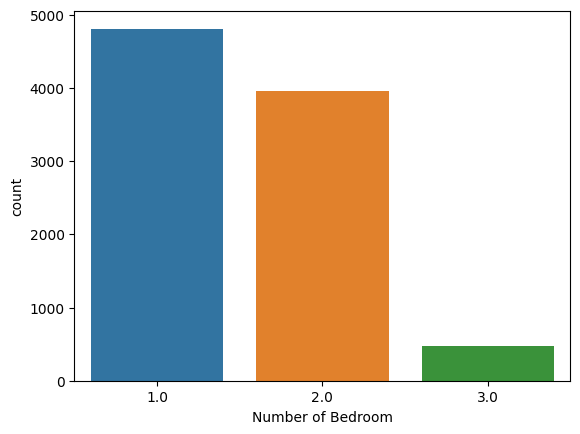

In [21]:
import seaborn as sns
sns.countplot(x = df['Number of Bedroom'])

In [22]:
avg_price = df.groupby(df['Number of Bedroom']).mean().round()
print(avg_price)

                    Price
Number of Bedroom        
1.0                2257.0
2.0                2815.0
3.0                3161.0


C:\Users\Tu\AppData\Local\Temp\ipykernel_20068\3848901673.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_price = df.groupby(df['Number of Bedroom']).mean().round()


Text(0.5, 1.0, 'Prices by Areas')

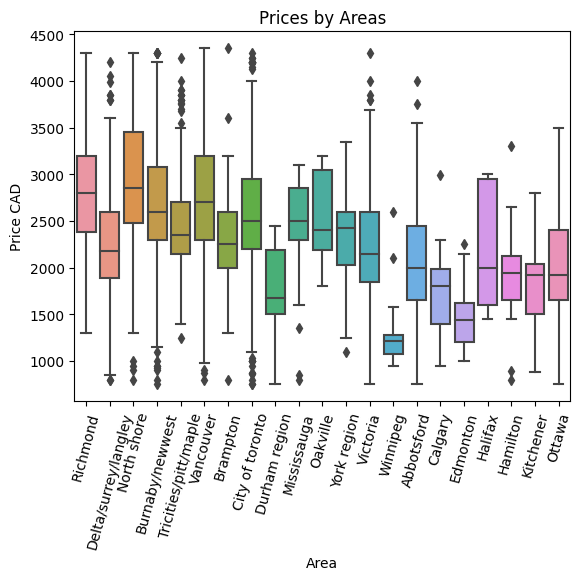

In [23]:
from matplotlib import pyplot as plt

sns.boxplot(x='Area', y='Price', data=df)
plt.xlabel("Area")
plt.xticks(rotation=75)
plt.ylabel("Price CAD")
plt.title("Prices by Areas")

Step 2. Connect to the MySQL and create a database

In [ ]:
import mysql.connector as msql
from mysql.connector import Error

try:
    conn = msql.connect(host="127.0.0.1", port="3306", user="root", password="trinhviettud22", auth_plugin="mysql_native_password")
    if conn.is_connected():
        cursor = conn.cursor()
        cursor.execute("CREATE DATABASE craigslist_housing")
        print("craigslist_housing database is created")
except Error:
        print("Error while connecting to MySQL", Error )


Error while connecting to MySQL <class 'mysql.connector.errors.Error'>


In [ ]:
import mysql.connector 
df = df.fillna(0)

try:
    conn = mysql.connector.connect(host="127.0.0.1", database = 'craigslist_housing', port="3306", user="root", password="", auth_plugin="mysql_native_password")
    if conn.is_connected():
        cursor = conn.cursor() #A cursor is an object which helps to execute the query and fetch the records from the database. 
        cursor.execute("select database();")
        record = cursor.fetchone()
        #print("You're connected to database: ", record)
        cursor.execute('DROP TABLE IF EXISTS craigslist_housing.postings')
        #print('Creating table...')
        cursor.execute("CREATE TABLE postings ( Title VARCHAR(500) NOT NULL, Area VARCHAR(100) NOT NULL, Address VARCHAR(500), Price FLOAT(4,0) , Date DATE,Number_of_bedroom ENUM('1.0','2.0','3.0'), Square_Feet FLOAT(4,0), URL VARCHAR(1000) NOT NULL)")
        #print('Table has been created!')
        for i,row in df.iterrows():
            #print(tuple(row))
            sql = 'INSERT INTO craigslist_housing.postings VALUES (%s,%s,%s,%s,%s,%s,%s,%s)'
            cursor.execute(sql, tuple(row))
            print("Record inserted")
            conn.commit()
except mysql.connector.Error as err:
    print("Something went wrong: {}".format(err))

In [ ]:
print(len(df))

6600
